In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import string
from tqdm import tqdm
import re
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [2]:
token_dict = {letter:i for letter,i in zip(string.ascii_lowercase, range(1,27))}
token_dict[' '] = 0
token_dict['\n'] = 27

class TextDataset(Dataset):
    def __init__(self, sentences, idx):
        self.data = []

        self.max_len = max([len(x) for x in sentences])

        for sentence in sentences:
            if len(sentence) > idx:
                x = torch.tensor([token_dict[x] for x in sentence[:idx]], dtype=torch.int64, device=device)
                y = torch.tensor(token_dict[sentence[idx]], dtype=torch.int64, device=device)
                self.data.append((x, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

In [3]:
sentences_file = 'sentences.txt'

In [4]:
allowed_chars = set(string.ascii_lowercase + ' \n')

In [5]:
sentences = []
with open(sentences_file, 'r') as f:
    sentences = f.readlines()
sentences = [x.replace('\'', '') for x in sentences]
sentences = [re.sub('\W+', ' ', x.lower()).strip() for x in sentences]

sentences = list(set(sentences))

In [6]:
def print_info(sentences):
    # Length of alphabet used
    print('token set length: ', len(list(set(''.join(sentences)))))

    ## Number of unique words
    print('unique words: ', len(list(' '.join(sentences).split(' '))))
    print('word vocabulary length: ', len(list(set(' '.join(sentences).split(' ')))))

In [ ]:
print_info(sentences)

token set length:  34
unique words:  111731
word vocabulary length:  4125


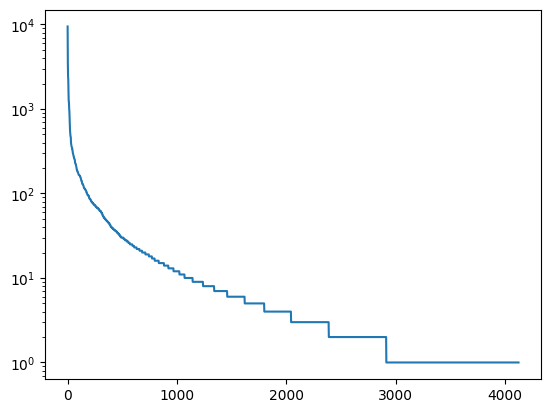

In [9]:
plt.plot(pd.DataFrame(list(' '.join(sentences).split(' '))).value_counts().values)
plt.yscale('log')

In [10]:
map_dict = {x[0]:y for x,y in 
            pd.DataFrame(list(' '.join(sentences).split(' ')))\
                .value_counts().to_dict().items()}

common_sentences = []

for sentence in sentences:
    good = True

    for word in sentence.split(' '):
        if map_dict[word] < 10:
            good = False
            break

    for char in sentence:
        if char not in allowed_chars:
            good = False
            break
    
    if good:
        common_sentences.append(sentence + '\n')

random.shuffle(common_sentences)

In [13]:
print_info(common_sentences)

token set length:  28
unique words:  73336
word vocabulary length:  2001


## Model

In [14]:
class GRUTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout_prob=0.1):
        super(GRUTextGenerator, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        
        self.embedding_ff = nn.Linear(vocab_size, embed_size, bias=False)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        
        self.gru1 = nn.GRU(embed_size, hidden_size, 1, batch_first=True)
        self.gru2 = nn.GRU(hidden_size, hidden_size, 1, batch_first=True)
        self.gru3 = nn.GRU(hidden_size, hidden_size, 1, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_length)
        x = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        embedded = self.embedding_ff(x)
        embedded = self.dropout(embedded)  # Apply dropout to the embedded input
        
        x, hidden1 = self.gru1(embedded, hidden)  # Optionally pass hidden state
        x = self.dropout(x)  # Apply dropout after first GRU
        
        x, hidden2 = self.gru2(x, hidden1) 
        x = self.dropout(x)  # Apply dropout after second GRU
        
        x, hidden3 = self.gru3(x, hidden2)
        x = self.dropout(x)  # Apply dropout after third GRU
        
        logits = self.fc(x)  # (batch_size, seq_length, vocab_size)
        return logits, hidden3


In [15]:
# Example hyperparameters
vocab_size = 28  # a-z and space, \n chars
embed_size = 256
hidden_size = 512
batch_size = 64

# Create the model
model = GRUTextGenerator(vocab_size, embed_size, hidden_size)

In [17]:
def load_model(model, model_path, device):
    # Load the saved model state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")

# load_model(model, 'model_cache/model_epoch_41.pt', device)

## Training

In [18]:
def train(model, dataloaders, vocab_size, device, epochs=10, startepoch=0, lr=0.0001, save_dir='model_cache'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.to(device)
    model.train()

    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for epoch in range(startepoch, epochs):
        total_loss = 0
        for data_loader in dataloaders:
            for _, (inputs, targets) in enumerate(data_loader, 0):
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                
                logits, _ = model(inputs)  # (batch_size, seq_length, vocab_size)
                logits = logits[:, -1, :]
                logits = logits.view(-1, vocab_size)  # Reshape for loss calculation
                targets = targets.view(-1)  # Reshape to match logits
                
                loss = criterion(logits, targets)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

        # Save the model after each epoch
        model_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), model_path)
        # print(f"Model saved to {model_path}")


In [20]:
import csv

def log_epoch_to_csv(csv_path, epoch, train_loss, val_loss):
    """
    Appends epoch number, training loss, and validation loss to a CSV file.

    Args:
        csv_path (str): Path to the CSV file.
        epoch (int): The current epoch number.
        train_loss (float): Training loss for the epoch.
        val_loss (float): Validation loss for the epoch.
    """
    write_header = not os.path.exists(csv_path)  # Check if the file exists

    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if write_header:
            writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])
        writer.writerow([epoch, train_loss, val_loss])


In [24]:
import os
import torch
from torch import nn, optim


def train_epoch(model, dataloaders, criterion, optimizer, vocab_size, device):
    """
    Performs one epoch of training.

    Args:
        model: The model to train.
        dataloaders: List of training dataloaders.
        criterion: Loss function.
        optimizer: Optimizer for model training.
        vocab_size: Size of the vocabulary.
        device: Device to use for training.

    Returns:
        float: Average training loss for the epoch.
    """
    model.train()
    total_loss = 0
    for data_loader in dataloaders:
        for _, (inputs, targets) in enumerate(data_loader, 0):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            logits, _ = model(inputs)  # (batch_size, seq_length, vocab_size)
            logits = logits[:, -1, :]
            logits = logits.view(-1, vocab_size)  # Reshape for loss calculation
            targets = targets.view(-1)  # Reshape to match logits

            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
    return total_loss / sum(len(dl) for dl in dataloaders)


def val_epoch(model, dataloaders, criterion, vocab_size, device):
    """
    Performs one epoch of evaluation.

    Args:
        model: The model to evaluate.
        dataloaders: List of validation dataloaders.
        criterion: Loss function.
        vocab_size: Size of the vocabulary.
        device: Device to use for evaluation.

    Returns:
        float: Average validation loss for the epoch.
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data_loader in dataloaders:
            for _, (inputs, targets) in enumerate(data_loader, 0):
                inputs, targets = inputs.to(device), targets.to(device)

                logits, _ = model(inputs)  # (batch_size, seq_length, vocab_size)
                logits = logits[:, -1, :]
                logits = logits.view(-1, vocab_size)  # Reshape for loss calculation
                targets = targets.view(-1)  # Reshape to match logits

                loss = criterion(logits, targets)
                total_loss += loss.item()
    return total_loss / sum(len(dl) for dl in dataloaders)


def train(
    model, 
    train_dataloaders, 
    test_dataloaders, 
    vocab_size, 
    device, 
    epochs=10, 
    startepoch=0, 
    lr=0.0001, 
    save_dir='model_cache'
):
    """
    Train the model with a training and validation loop.

    Args:
        model: The model to train.
        train_dataloaders: List of training dataloaders.
        test_dataloaders: List of validation dataloaders.
        vocab_size: Size of the vocabulary.
        device: Device to use for training.
        epochs: Number of training epochs.
        startepoch: Starting epoch number for resuming training.
        lr: Learning rate for optimizer.
        save_dir: Directory to save model checkpoints.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    if startepoch != 0:
        load_model(model, f'model_cache/model_epoch_{startepoch}.pt', device)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(startepoch, epochs):
        train_loss = train_epoch(
            model, train_dataloaders, criterion, optimizer, vocab_size, device
        )
        val_loss = val_epoch(
            model, test_dataloaders, criterion, vocab_size, device
        )

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Validation Loss: {val_loss:.4f}")

        log_epoch_to_csv('train_log.csv', epoch, train_loss, val_loss)

        # Save the model after each epoch
        model_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), model_path)


In [25]:
common_sentences = common_sentences[:10]

In [26]:
tt_split = 0.9
split_loc = int(tt_split * len(common_sentences))

train_dataloaders = []
test_dataloaders = []

for i in range(1, max([len(x) for x in common_sentences])):
    test_dataset = TextDataset(common_sentences[split_loc:], i)
    train_dataset = TextDataset(common_sentences[:split_loc], i)

    train_dataloaders.append(DataLoader(train_dataset, batch_size))
    test_dataloaders.append(DataLoader(test_dataset, batch_size))

# train(model, dataloaders, vocab_size, device, epochs=60, startepoch=42)
train(model, train_dataloaders, test_dataloaders, vocab_size, device, epochs=100)

Epoch 1/100
  Train Loss: 0.0682
  Validation Loss: 4.1225
Epoch 2/100
  Train Loss: 0.0694
  Validation Loss: 3.9473
Epoch 3/100
  Train Loss: 0.0694
  Validation Loss: 4.0263
Epoch 4/100
  Train Loss: 0.0712
  Validation Loss: 4.9881
Epoch 5/100
  Train Loss: 0.1336
  Validation Loss: 3.7347
Epoch 6/100
  Train Loss: 0.1551
  Validation Loss: 4.5749
Epoch 7/100
  Train Loss: 0.1492
  Validation Loss: 3.9668
Epoch 8/100
  Train Loss: 0.0937
  Validation Loss: 4.2988


KeyboardInterrupt: 

# Inference

In [34]:
def vectorise(sentence):
    return torch.tensor([token_dict[x] for x in sentence], dtype=torch.int64, device=device)

def softmax(logits, temperature=1.0):
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))
    probs = exp_logits / exp_logits.sum()
    return probs

def run_inference(model, sentence, temperature=1.0):
    model.eval()

    input = vectorise(sentence)

    output = model(input)

    logits = output[0][-1, :].detach().numpy()

    # print(logits)

    # Compute probabilities using softmax with temperature
    probs = softmax(logits, temperature)

    # Randomly sample from the probability distribution
    sampled_idx = np.random.choice(len(probs), p=probs)

    # sampled_idx = np.argmax(logits)
    # print(sampled_idx)

    # Find the corresponding token
    for a, i in token_dict.items():
        if sampled_idx == i:
            sentence += a
            return sentence

In [40]:
sentence = random.sample(string.ascii_lowercase, 1)[0]
sentence = 'the'
print(sentence, end='')

while sentence[-1] != '\n':
    sentence = run_inference(model, sentence, temperature=0.6)
    print(sentence[-1], end='')

the view from the mountain is great


In [37]:
import numpy as np
import json
from json import JSONEncoder


In [38]:
class EncodeTensor(JSONEncoder,Dataset):
    def default(self, obj):
        if isinstance(obj, torch.Tensor):
            return obj.cpu().detach().numpy().tolist()
        return super(json.NpEncoder, self).default(obj)


In [ ]:
# x = vectorise(sentence)
# y = model(x)[0]

# np.savetxt('test_data/generative_gru_x.csv', x.detach(), delimiter=',')
# np.savetxt('test_data/generative_gru_y.csv', y.detach(), delimiter=',')

with open('models/generative_gru.json', 'w') as json_file:
    json.dump(model.state_dict(), json_file,cls=EncodeTensor)